In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Image Generation from Audio

In [2]:
from pathlib import Path
from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from utils import read_file, transform_path

In [3]:
DATA = Path('data')

# these folders must be in place
NSYNTH_AUDIO = DATA/'nsynth_audio'
TRAIN_AUDIO_PATH = NSYNTH_AUDIO/'train'
VALID_AUDIO_PATH = NSYNTH_AUDIO/'valid'

# these folders will be created
NSYNTH_IMAGES = DATA/'nsynth_images'
TRAIN_IMAGE_PATH = NSYNTH_IMAGES/'train'
VALID_IMAGE_PATH = NSYNTH_IMAGES/'valid'

In [4]:
train_acoustic_fnames = [f.name for f in TRAIN_AUDIO_PATH.iterdir()
                         if 'acoustic' in f.name]
valid_acoustic_fnames = [f.name for f in VALID_AUDIO_PATH.iterdir()
                         if 'acoustic' in f.name]
len(train_acoustic_fnames), len(valid_acoustic_fnames)

(102165, 5124)

In [5]:
fn = train_acoustic_fnames[8]; fn

'keyboard_acoustic_001-098-127.wav'

In [6]:
Audio(str(TRAIN_AUDIO_PATH/fn))

In [7]:
x, sr = read_file(fn, TRAIN_AUDIO_PATH)
x.shape, sr, x.dtype

((64000,), 16000, dtype('float32'))

In [8]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    x, sample_rate = read_file(fname, src_path)
    
    n_fft = 1024
    hop_length = 256
    n_mels = 40
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
    dst_fname = dst_path / (fname[:-4] + '.png')
    plt.imsave(dst_fname, mel_spec_db)

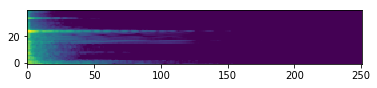

In [9]:
log_mel_spec_tfm(fn, TRAIN_AUDIO_PATH, Path('.'))
img = plt.imread(fn[:-4] + '.png')
plt.imshow(img, origin='lower');

In [10]:
# TRAIN files took 10m43s

# transform_path(TRAIN_AUDIO_PATH, TRAIN_IMAGE_PATH, log_mel_spec_tfm, 
#                fnames=train_acoustic_fnames, delete=True)

In [11]:
# VALID files took  0m31s
# transform_path(VALID_AUDIO_PATH, VALID_IMAGE_PATH, log_mel_spec_tfm, 
#                fnames=valid_acoustic_fnames, delete=True)

### Run Image Classifier

In [12]:
import fastai
fastai.__version__

'1.0.43.post1'

In [13]:
from fastai.vision import *

In [14]:
instrument_family_pattern = r'(\w+)_\w+_\d+-\d+-\d+.png$'

data = (ImageItemList.from_folder(NSYNTH_IMAGES)
            .split_by_folder()
            .label_from_re(instrument_family_pattern)
            .databunch())
data.c, data.classes

(10,
 ['bass',
  'brass',
  'flute',
  'guitar',
  'keyboard',
  'mallet',
  'organ',
  'reed',
  'string',
  'vocal'])

In [15]:
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([64, 3, 40, 251]), torch.Size([64]))

In [16]:
xs.min(), xs.max(), xs.mean(), xs.std()

(tensor(0.0039), tensor(0.9922), tensor(0.2933), tensor(0.1998))

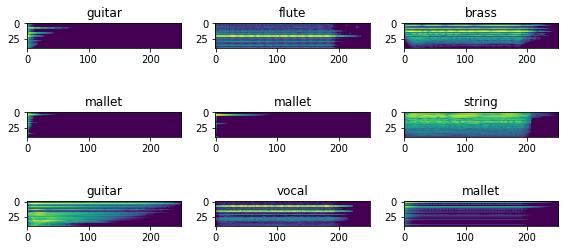

In [17]:
data.show_batch(3, figsize=(8,4), hide_axis=False)

In [18]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy
1,0.313827,0.811616,0.785129
2,0.151042,0.714431,0.837237
3,0.095302,0.749151,0.840359


In [19]:
interp = ClassificationInterpretation.from_learner(learn)

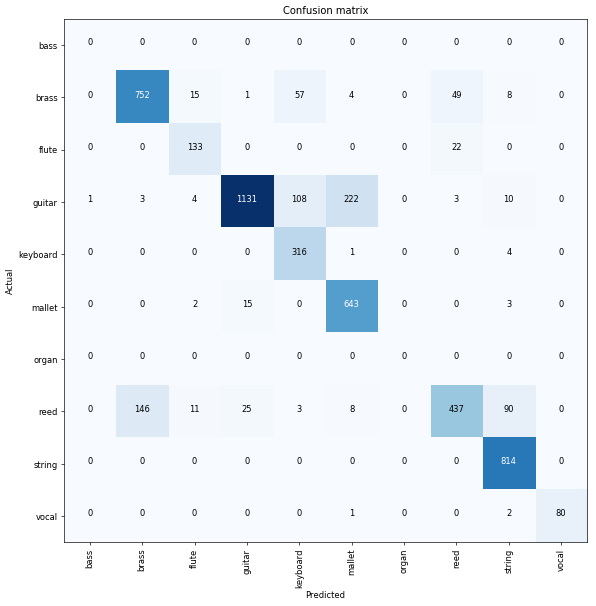

In [20]:
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

In [21]:
interp.most_confused(min_val=20)

[('guitar', 'mallet', 222),
 ('reed', 'brass', 146),
 ('guitar', 'keyboard', 108),
 ('reed', 'string', 90),
 ('brass', 'keyboard', 57),
 ('brass', 'reed', 49),
 ('reed', 'guitar', 25),
 ('flute', 'reed', 22)]